<a href="https://colab.research.google.com/github/Chubbyman2/Medical_Image_Classifier/blob/main/ResNet50_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WARNING: Images shown are quite graphic. Viewer disrection is advised.**

In [23]:
import os
import keras
import numpy as np
from keras import optimizers, models, layers
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D
from keras.models import Model, Sequential
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

!unzip "/content/drive/My Drive/kvasir-dataset-v2.zip"

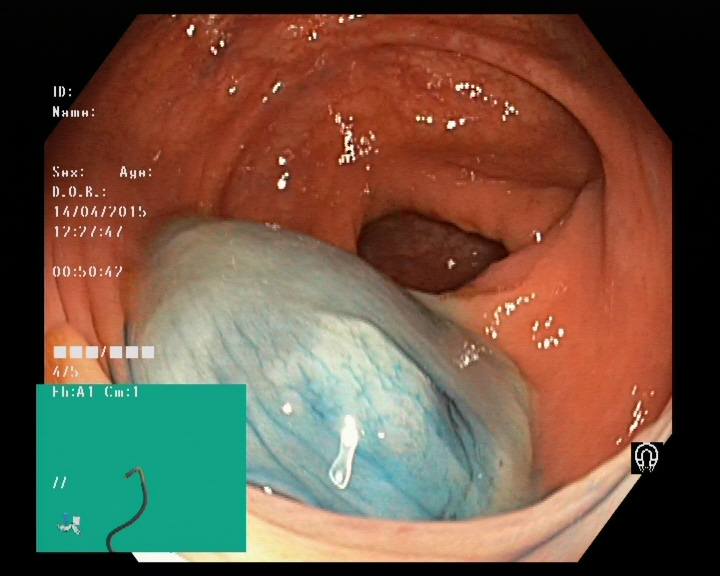

In [3]:
# Image sample from dataset
from IPython.display import Image

img = Image("kvasir-dataset-v2/dyed-lifted-polyps/0a7bdce4-ac0d-44ef-93ee-92dfc8fe0b81.jpg")
img

In [4]:
# Create a dictionary of the classes and a reverse dictionary
classes = dict()
reverse_classes = dict()
count = 0
for folder in os.listdir("kvasir-dataset-v2"):
    classes[folder] = count
    reverse_classes[count] = img
    count = count + 1

classes

{'dyed-lifted-polyps': 5,
 'dyed-resection-margins': 3,
 'esophagitis': 2,
 'normal-cecum': 7,
 'normal-pylorus': 6,
 'normal-z-line': 0,
 'polyps': 4,
 'ulcerative-colitis': 1}

In [5]:
from PIL import Image

def get_data(stop):
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for class_folder in os.listdir("kvasir-dataset-v2/"):
      print(f"Processing {class_folder}...")
      count = 0
      count2 = 0
      for img in os.listdir(f"kvasir-dataset-v2/{class_folder}/"):
        # For training dataset
        if count < stop:
          image = Image.open(f"kvasir-dataset-v2/{class_folder}/{img}")
          image = image.resize((224, 224))
          arr = np.array(image)
          x_train.append(arr)
          count += 1

        # For validation dataset
        else:
          image = Image.open(f"kvasir-dataset-v2/{class_folder}/{img}")
          image = image.resize((224, 224))
          arr = np.array(image)
          x_test.append(arr)
          count2 += 1
          
      y_values = np.full((count, 1), classes[class_folder])
      y_train.append(y_values)
      y_values2 = np.full((count2, 1), classes[class_folder])
      y_test.append(y_values2)
         
    return x_train, y_train, x_test, y_test

In [6]:
# Normalizes data, converts to numpy arrays
def process_data(x_data, y_data):
    x_data = np.array(x_data, dtype = "float32")
    x_data = x_data.reshape((len(x_data), 224, 224, 3))
    x_data /= 255
    
    y_data = np.array(y_data)
    y_data = y_data.reshape(len(x_data), 1)
    y_data = to_categorical(y_data)
    return x_data, y_data

In [7]:
# Split dataset 80/20
X_train, y_train, X_test, y_test = get_data(800)

# Process data, convert to numpy arrays
X_train, y_train = process_data(X_train, y_train)
X_test, y_test = process_data(X_test, y_test)

Processing normal-z-line...
Processing ulcerative-colitis...
Processing esophagitis...
Processing dyed-resection-margins...
Processing polyps...
Processing dyed-lifted-polyps...
Processing normal-pylorus...
Processing normal-cecum...


In [8]:
BATCH_SIZE = 64

# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=[0.95, 1.05],
    horizontal_flip=True)

datagen.fit(X_train)

In [26]:
# Transfer learning, ResNet50
from keras.applications.resnet50 import ResNet50
new_input = Input(shape=(224, 224, 3))
base_model = ResNet50(include_top=False, input_tensor=new_input)
base_model.trainable = False # Make sure the transfer model isn't trained
model = Sequential([base_model, 
                    Flatten(),
                    Dropout(0.25),
                    Dense(512, activation="relu"),
                    Dense(8, activation="softmax")])

In [28]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
early_stopping = EarlyStopping(patience=3)
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), steps_per_epoch = len(X_train)/BATCH_SIZE, epochs=20, callbacks=[early_stopping], validation_data=(X_test, y_test))

Epoch 1/20
100/100 [==============================] - 63s 632ms/step - loss: 11.6824 - accuracy: 0.2892 - val_loss: 5.4365 - val_accuracy: 0.1250
Epoch 2/20
100/100 [==============================] - 62s 621ms/step - loss: 2.2407 - accuracy: 0.3789 - val_loss: 2.8791 - val_accuracy: 0.1250
Epoch 3/20
100/100 [==============================] - 62s 617ms/step - loss: 1.5235 - accuracy: 0.4252 - val_loss: 2.4573 - val_accuracy: 0.1250
Epoch 4/20
100/100 [==============================] - 62s 616ms/step - loss: 1.3246 - accuracy: 0.4670 - val_loss: 2.5178 - val_accuracy: 0.1250
Epoch 5/20
100/100 [==============================] - 61s 613ms/step - loss: 1.1831 - accuracy: 0.4988 - val_loss: 2.5894 - val_accuracy: 0.1256
Epoch 6/20
100/100 [==============================] - 61s 615ms/step - loss: 1.1511 - accuracy: 0.5147 - val_loss: 2.8381 - val_accuracy: 0.1163


In [30]:
model.save("ResNet50_classifier.h5")

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_6 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 4104      
Total params: 74,972,552
Trainable params: 51,384,840
Non-trainable params: 23,587,712
_________________________________________________________________


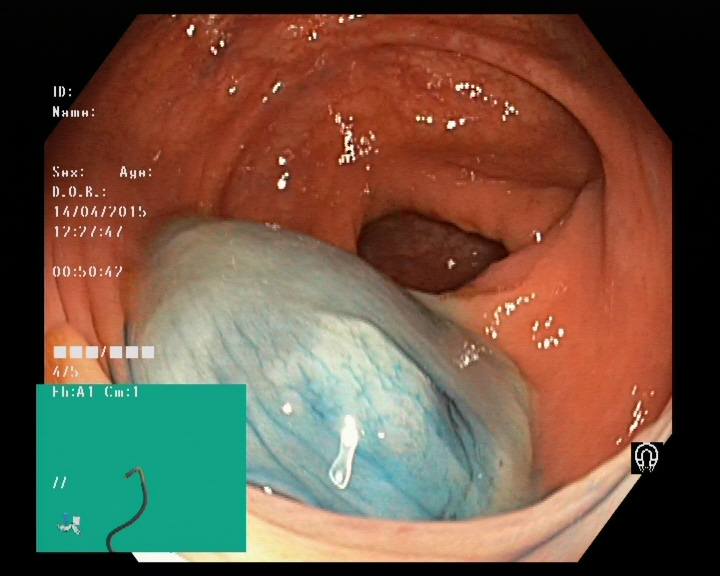

In [32]:
# Model predicts the image sample correctly
image = Image.open(f"kvasir-dataset-v2/dyed-lifted-polyps/0a7bdce4-ac0d-44ef-93ee-92dfc8fe0b81.jpg")
image = image.resize((224, 224))
arr = np.array(image)
x_data = [arr]
x_data = np.array(x_data, dtype = "float32")
x_data = x_data.reshape((len(x_data), 224, 224, 3))
x_data /= 255

pred_array = model.predict(x_data)
result = reverse_classes[np.argmax(pred_array)]
result

**Plot Training and Validation Graphs**

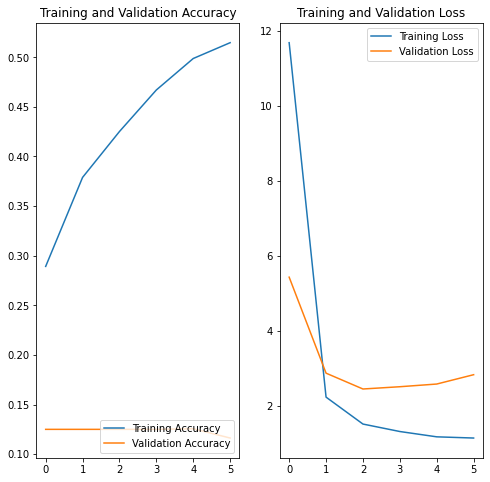

In [34]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()